## Topic modeling
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
nlp = spacy.load("en_core_web_md")

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
# Import Dataset
df = pd.read_json('data_prep.json')
print(df.sector.unique())
df.head()

['Financial Services' 'Healthcare' 'Communication Services'
 'Consumer Defensive' 'Basic Materials' 'Industrials' 'Consumer Cyclical'
 'Energy & Utility' 'Real Estate' 'Technology']


,description,sector
0,Adara Acquisition Corp. does not have signific...,Financial Services
1,"AIM ImmunoTech Inc., an immuno-pharma company,...",Healthcare
2,"Ashford, Inc is an asset management firm. The ...",Financial Services
3,"The Arena Group Holdings, Inc., together with ...",Communication Services
4,"AMCON Distributing Company, together with its ...",Consumer Defensive


In [5]:
# Convert to list
data = df.description.values.tolist()

# Remove Emails
# data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
# data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
# data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Adara Acquisition Corp. does not have significant operations. The company '
 'intends to effect a merger, capital stock exchange, asset acquisition, stock '
 'purchase, reorganization, or similar business combination with one or more '
 'businesses. It focuses on searching for businesses in the consumer products '
 'industry and related sectors, including those consumer industry businesses '
 'in the health and wellness, e-commerce, discretionary spending, and '
 'information technology sectors and related channels of distribution. The '
 'company was incorporated in 2020 and is based in Charlotte, North Carolina.']


In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['adara', 'acquisition', 'corp', 'does', 'not', 'have', 'significant', 'operations', 'the', 'company', 'intends', 'to', 'effect', 'merger', 'capital', 'stock', 'exchange', 'asset', 'acquisition', 'stock', 'purchase', 'reorganization', 'or', 'similar', 'business', 'combination', 'with', 'one', 'or', 'more', 'businesses', 'it', 'focuses', 'on', 'searching', 'for', 'businesses', 'in', 'the', 'consumer', 'products', 'industry', 'and', 'related', 'sectors', 'including', 'those', 'consumer', 'industry', 'businesses', 'in', 'the', 'health', 'and', 'wellness', 'commerce', 'discretionary', 'spending', 'and', 'information', 'technology', 'sectors', 'and', 'related', 'channels', 'of', 'distribution', 'the', 'company', 'was', 'incorporated', 'in', 'and', 'is', 'based', 'in', 'charlotte', 'north', 'carolina']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)  # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['adara', 'acquisition_corp_does', 'not_have_significant_operations', 'the', 'company', 'intends', 'to', 'effect_merger_capital', 'stock_exchange_asset', 'acquisition_stock_purchase', 'reorganization_or_similar', 'business', 'combination', 'with', 'one', 'or_more_businesses', 'it', 'focuses_on', 'searching', 'for', 'businesses', 'in', 'the', 'consumer', 'products', 'industry', 'and', 'related', 'sectors', 'including', 'those', 'consumer', 'industry', 'businesses', 'in', 'the', 'health', 'and', 'wellness', 'commerce', 'discretionary', 'spending', 'and', 'information', 'technology', 'sectors', 'and', 'related', 'channels', 'of', 'distribution', 'the', 'company', 'was', 'incorporated', 'in', 'and', 'is', 'based', 'in', 'charlotte_north_carolina']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['significant_operation', 'company', 'intend', 'capital', 'asset', 'acquisition', 'stock_purchase', 'reorganization', 'similar', 'business', 'combination', 'business', 'focus', 'search', 'business', 'consumer', 'product', 'industry', 'relate', 'sector', 'include', 'consumer', 'industry', 'business', 'health', 'commerce', 'discretionary', 'spending', 'information', 'technology', 'sector', 'relate', 'channel', 'distribution', 'company', 'incorporate', 'base']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 4), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)]]


In [11]:
# Human-readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('acquisition', 1),
  ('asset', 1),
  ('base', 1),
  ('business', 4),
  ('capital', 1),
  ('channel', 1),
  ('combination', 1),
  ('commerce', 1),
  ('company', 2),
  ('consumer', 2),
  ('discretionary', 1),
  ('distribution', 1),
  ('focus', 1),
  ('health', 1),
  ('include', 1),
  ('incorporate', 1),
  ('industry', 2),
  ('information', 1),
  ('intend', 1),
  ('product', 1),
  ('relate', 2),
  ('reorganization', 1),
  ('search', 1),
  ('sector', 2),
  ('significant_operation', 1),
  ('similar', 1),
  ('spending', 1),
  ('stock_purchase', 1),
  ('technology', 1)]]

In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.076*"service" + 0.055*"solution" + 0.032*"provide" + 0.026*"management" + '
  '0.022*"technology" + 0.021*"software" + 0.021*"system" + 0.019*"company" + '
  '0.016*"offer" + 0.013*"communication"'),
 (1,
  '0.035*"product" + 0.030*"system" + 0.022*"equipment" + 0.019*"company" + '
  '0.018*"manufacture" + 0.017*"segment" + 0.016*"material" + 0.016*"offer" + '
  '0.014*"sell" + 0.013*"industrial"'),
 (2,
  '0.058*"invest" + 0.042*"fund" + 0.038*"good" + 0.033*"portfolio" + '
  '0.027*"market" + 0.025*"firm" + 0.024*"company" + 0.024*"manage" + '
  '0.021*"investment" + 0.018*"stock"'),
 (3,
  '0.062*"international" + 0.044*"derivative" + 0.030*"eye" + 0.026*"canadian" '
  '+ 0.026*"combine" + 0.018*"double" + 0.018*"foreign_exchange" + '
  '0.016*"option" + 0.015*"mountain" + 0.014*"authority"'),
 (4,
  '0.054*"company" + 0.031*"business" + 0.024*"engage" + 0.019*"production" + '
  '0.018*"incorporate" + 0.017*"project" + 0.017*"base" + 0.016*"film" + '
  '0.016*"operate" + 0

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.7375897555076065

Coherence Score:  0.4715459446652397


In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\esse\anaconda3\envs\topic_modeling\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.265718 -0.028368       1        1  28.323374
1      0.234474 -0.151520       2        1  23.809565
0      0.215865  0.057733       3        1  16.574647
4      0.134701  0.041675       4        1   8.361079
6      0.047888 -0.125510       5        1   8.246196
5     -0.039626  0.308502       6        1   6.734935
2     -0.138786  0.194923       7        1   4.098844
9     -0.221708 -0.141309       8        1   2.155795
8     -0.250430 -0.091287       9        1   1.245251
3     -0.248098 -0.064839      10        1   0.450314, topic_info=              Term          Freq         Total Category  logprob  loglift
81         service  16202.000000  16202.000000  Default  30.0000  30.0000
264       solution   6305.000000   6305.000000  Default  29.0000  29.0000
78      management   6062.000000   6062.000000  Default  28.0000  28.0000
77      investment   3227.000000   3227.000000  Default  27.0000  27.0000
8          company  20901.000000  20901.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
646     purchasing     15.221398     16.285344  Topic10  -5.3264   5.3354
703       clearing     14.644972     15.708924  Topic10  -5.3650   5.3328
3107  fixed_income     12.043224     13.107130  Topic10  -5.5606   5.3183
6969          swap     11.429485     12.493402  Topic10  -5.6129   5.3140
717         option     50.235166    110.811662  Topic10  -4.1324   4.6119

[514 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
723       3  0.998672       access
0         4  0.747091  acquisition
0         6  0.251358  acquisition
1079      1  0.875931     activity
1079      2  0.123040     activity
...     ...       ...          ...
6793     10  0.972474         wide
735       8  0.998069     wireless
2030      5  0.997599        woman
946       6  0.994575         year
482       4  0.992679         zinc

[675 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 1, 5, 7, 6, 3, 10, 9, 4])

The area of these topic circles is proportional to the amount of words that belong to each topic across the dictionary. When you select a topic in the intertopic distance map, or specify a topic in the top panel, the bar chart changes to display the most salient words included in that specific topic. A second darker bar is also displayed over the term’s total frequency that shows the topic-specific frequency of words that belong to the selected topic. If the dark bar entirely eclipses the light bar, that term nearly exclusively belongs to the selected topic. When you select a word in the bar chart, the topics and probabilities by topic of that word are displayed in the intertopic distance map, so you can see which other topics a term might be shared with. You can adjust the words displayed in the bar chart for a topic by adjusting the λ (lambda) slider. Adjusting lambda to values close to 0 highlights potentially rare but more exclusive terms for the selected topic. Larger lambda values (closer to 1) highlight more frequently occurring terms in the document that might not be exclusive to the topic. The authors of this visualization found in a user study that a λ value close to 0.6 was optimal for interpreting the topics, although they expected this value to change based on the data and individual topics.

In [17]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = 'C:\\Users\\esse\\OneDrive\\Dokumente\\GitHub\\project_NLP\\mallet-2.0.8'
mallet_path = 'C:\\Users\\esse\\OneDrive\\Dokumente\\GitHub\\project_NLP\\mallet-2.0.8\\bin\\mallet'

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [18]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('operate', 0.06212535783763266),
   ('company', 0.03960333401869454),
   ('store', 0.0227276321824537),
   ('found', 0.021335821721732803),
   ('brand', 0.020149619624527496),
   ('retail', 0.019169025890837774),
   ('include', 0.014487481613867493),
   ('home', 0.014044632830910845),
   ('offer', 0.013839024467395258),
   ('subsidiary', 0.011988549195754978)]),
 (1,
  [('develop', 0.04328889856740655),
   ('treatment', 0.038420258520120085),
   ('company', 0.03786028714087947),
   ('development', 0.016954688982563113),
   ('patient', 0.01474591298666957),
   ('include', 0.013890401157274183),
   ('disease', 0.013610415467653875),
   ('clinical_trial', 0.012646020314517259),
   ('cell', 0.012039384653673256),
   ('medical', 0.011697179921915102)]),
 (2,
  [('service', 0.0875099072217819),
   ('solution', 0.04552659797659565),
   ('provide', 0.03819525385798872),
   ('management', 0.027367243228122524),
   ('platform', 0.02229707678679659),
   ('software', 0.021959065690708192)

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=24, step=6)

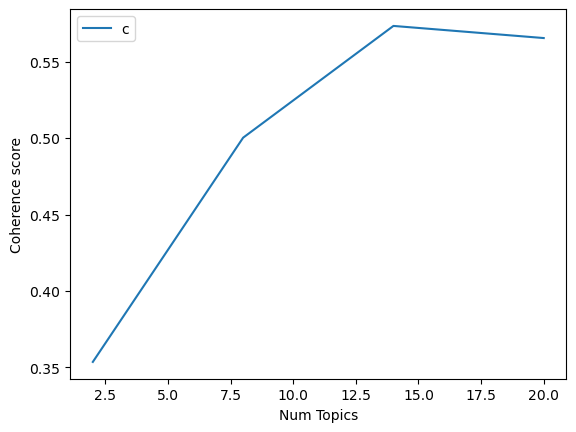

In [22]:
# Show graph
limit=24; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3536
Num Topics = 8  has Coherence Value of 0.5002
Num Topics = 14  has Coherence Value of 0.5734
Num Topics = 20  has Coherence Value of 0.5654


In [24]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.049*"invest" + 0.048*"investment" + 0.040*"fund" + 0.035*"market" + '
  '0.033*"manage" + 0.032*"portfolio" + 0.025*"equity" + 0.021*"security" + '
  '0.018*"primarily" + 0.017*"form"'),
 (1,
  '0.034*"energy" + 0.027*"gas" + 0.025*"oil" + 0.024*"water" + '
  '0.023*"company" + 0.020*"industrial" + 0.019*"chemical" + '
  '0.017*"natural_ga" + 0.016*"production" + 0.015*"storage"'),
 (2,
  '0.146*"service" + 0.043*"management" + 0.033*"provide" + 0.023*"sale" + '
  '0.021*"maintenance" + 0.019*"operation" + 0.019*"construction" + '
  '0.018*"relate" + 0.018*"support" + 0.017*"design"'),
 (3,
  '0.058*"product" + 0.035*"company" + 0.033*"medical" + 0.029*"health" + '
  '0.028*"offer" + 0.027*"care" + 0.021*"include" + 0.020*"provide" + '
  '0.013*"pharmaceutical" + 0.012*"device"'),
 (4,
  '0.054*"treatment" + 0.054*"develop" + 0.042*"company" + 0.019*"disease" + '
  '0.018*"clinical_trial" + 0.017*"cell" + 0.016*"development" + 0.016*"treat" '
  '+ 0.016*"cancer" + 0.016*"pati

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

C:\Users\esse\AppData\Local\Temp\ipykernel_17680\1150338244.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\esse\AppData\Local\Temp\ipykernel_17680\1150338244.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11,0.3182,"business, company, base, incorporate, asset, f...",Adara Acquisition Corp. does not have signific...
1,1,4,0.4457,"treatment, develop, company, disease, clinical...","AIM ImmunoTech Inc., an immuno-pharma company,..."
2,2,0,0.1290,"invest, investment, fund, market, manage, port...","Ashford, Inc is an asset management firm. The ..."
3,3,13,0.2291,"service, company, operate, offer, platform, di...","The Arena Group Holdings, Inc., together with ..."
4,4,12,0.4445,"product, brand, food, store, sell, operate, re...","AMCON Distributing Company, together with its ..."
5,5,0,0.4568,"invest, investment, fund, market, manage, port...","Aberdeen Emerging Markets Equity Income Fund, ..."
6,6,12,0.2612,"product, brand, food, store, sell, operate, re...",Acme United Corporation supplies first aid and...
7,7,0,0.4476,"invest, investment, fund, market, manage, port...","Aberdeen Australia Equity Fund, Inc. is a clos..."
8,8,4,0.4622,"treatment, develop, company, disease, clinical...","AgeX Therapeutics, Inc., a biotechnology compa..."
9,9,4,0.2908,"treatment, develop, company, disease, clinical...","Amylyx Pharmaceuticals, Inc., a biopharmaceuti..."


In [26]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.5856,"invest, investment, fund, market, manage, port...",Invesco Ltd. is a publicly owned investment ma...
1,1,0.5480,"energy, gas, oil, water, company, industrial, ...",CMS Energy Corporation operates as an energy c...
2,2,0.5142,"service, management, provide, sale, maintenanc...","OUTSOURCING Inc., together with its subsidiari..."
3,3,0.5395,"product, company, medical, health, offer, care...","Smith & Nephew plc, together with its subsidia..."
4,4,0.6716,"treatment, develop, company, disease, clinical...","Xencor, Inc., a clinical stage biopharmaceutic..."


In [27]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,11,"business, company, base, incorporate, asset, f...",960.0,0.0976
1,4,"treatment, develop, company, disease, clinical...",614.0,0.0624
2,0,"invest, investment, fund, market, manage, port...",500.0,0.0508
3,13,"service, company, operate, offer, platform, di...",528.0,0.0537
4,12,"product, brand, food, store, sell, operate, re...",843.0,0.0857
...,...,...,...,...
9828,6,"solution, software, provide, service, manageme...",NaN,NaN
9829,6,"solution, software, provide, service, manageme...",NaN,NaN
9830,9,"company, engage, operate, property, change, fo...",NaN,NaN
9831,5,"system, equipment, product, control, device, d...",NaN,NaN
